<a href="https://colab.research.google.com/github/MaxSMCON/Group07/blob/main/Group_7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# !pip install xlrd -U

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import re

# to make this notebook's output stable across runs
np.random.seed(10086)

def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


from functools import wraps
import inspect
def initializer(func): #https://stackoverflow.com/questions/1389180/automatically-initialize-instance-variables
    names, varargs, keywords, defaults = inspect.getfullargspec(func)[:4]
    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)
    return wrapper

In [3]:
# !pip install pandas==1.2.0 --force
pd.__version__


'1.3.5'


# Import Data
---

https://github.com/MaxSMCON/Group07/blob/9a48e9f2ed68ff433cec599ccaac8e4715f0e953/Census%20Data%20Adula%20Over%2050K.xlsm

In [4]:

url = "https://raw.githubusercontent.com/MaxSMCON/Group07/main/Census%20Data%20Adula%20Over%2050K.csv"
data = pd.read_csv(url)
data.head()

,Age,Work Class,fnlwgt: continuous.,Eduction,Education Number,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours Per Wk,Native Country,Income Level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
#column label cleanup
data.columns=data.columns.str.rstrip()
data.columns=data.columns.str.replace(' ','_')
data.head(2)

,Age,Work_Class,fnlwgt:_continuous.,Eduction,Education_Number,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Wk,Native_Country,Income_Level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [6]:
df=data

In [7]:
df.dtypes

Age                     int64
Work_Class             object
fnlwgt:_continuous.     int64
Eduction               object
Education_Number        int64
Martial_Status         object
Occupation             object
Relationship           object
Race                   object
Sex                    object
Capital_Gain            int64
Capital_Loss            int64
Hours_Per_Wk            int64
Native_Country         object
Income_Level           object
dtype: object

# Project Plan
<li> Clean the data
<li> Feature Contributions
<li> pipeline
<li> Classifiers - Random Forest
<li> Cross validation
<li> Grid Search, hyper
<li> ROC, presic
<li> Clustering - Create new targets
<li> Story - presentation

```
# This is formatted as code
```



## Jing & Ramila to take care of missing values

Jing's comments - Columns contain “?” are : Work class, Occupation  and Native Country. Hours per week is range from 1 to 99, I think it doesn’t make sense for too little or too many. Ages are a range from 17 to 90.

Ramila's Comment  - I have replace the "?" values with Other adn validated if hte code works 
Also i have added the code to create two classification >60 hours or  <60 hours if you need to use the new Column called Hour Class. 

In [8]:
#Pre Validation Data
df['Work_Class'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Work_Class, dtype: int64

In [9]:
#Code to replace "?" with Other for the three Columns 
df = df.replace({'Occupation': '\?', 'Native_Country': '\?','Work_Class':'\?' }, 
    {'Occupation': 'Other', 'Native_Country': 'Other', 'Work_Class': 'Other'}, regex=True)



In [10]:
# Evaluating if the ? is gone using Value Counts
df['Work_Class'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 Other                1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Work_Class, dtype: int64

In [11]:
df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Other                1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [12]:
df['Native_Country'].value_counts()

 United-States                 29170
 Mexico                          643
 Other                           583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [13]:
#Code to Create a column that defined the Hours worked Per week classified as More and Less than 60 Hours per Week 

df["Hours_Per_Wk"] = pd.to_numeric(df["Hours_Per_Wk"])


In [14]:
df['Hour_Class']=pd.cut(df['Hours_Per_Wk'],bins=[0,60,99],labels=["Less","More"])

In [15]:
df['Hour_Class'].value_counts()

Less    31451
More     1110
Name: Hour_Class, dtype: int64

## Panthea clean column headers

*   List item
*   List item



## David
<li> Prepare the story

## 

```
# This is formatted as code
```



## Sivi
<li> Clustering

# New Section



```SIVI to do Data visualization 
# This is formatted as code
```



Data Visualization-Sivi


In [16]:
import seaborn as sns

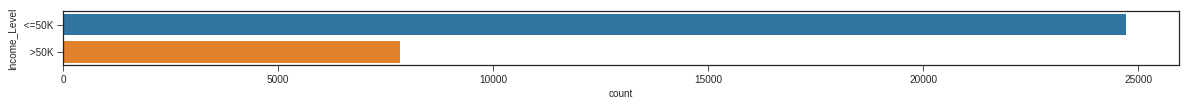

In [17]:
fig=plt.figure(figsize=(20,1))
plt.style.use('seaborn-ticks')
sns.countplot(y='Income_Level',data=df,order=df['Income_Level'].value_counts().index)

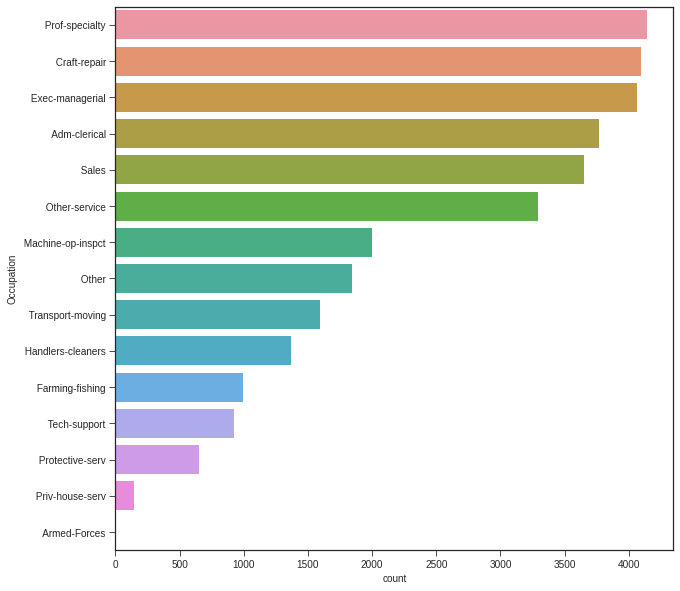

In [18]:
#Marital Status
fig=plt.figure(figsize=(10,10))
plt.style.use('seaborn-ticks')
sns.countplot(y='Occupation',data=df,order=df['Occupation'].value_counts().index)

In [19]:
df['Eduction'].replace(' Preschool', 'dropout',inplace=True)
df['Eduction'].replace(' 10th', 'dropout',inplace=True)
df['Eduction'].replace(' 11th', 'dropout',inplace=True)
df['Eduction'].replace(' 12th', 'dropout',inplace=True)
df['Eduction'].replace(' 1st-4th', 'dropout',inplace=True)
df['Eduction'].replace(' 5th-6th', 'dropout',inplace=True)
df['Eduction'].replace(' 7th-8th', 'dropout',inplace=True)
df['Eduction'].replace(' 9th', 'dropout',inplace=True)
df['Eduction'].replace(' HS-Grad', 'HighGrad',inplace=True)
df['Eduction'].replace(' HS-grad', 'HighGrad',inplace=True)
df['Eduction'].replace(' Some-college', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Assoc-acdm', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Assoc-voc', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Bachelors', 'Bachelors',inplace=True)
df['Eduction'].replace(' Masters', 'Masters',inplace=True)
df['Eduction'].replace(' Prof-school', 'Masters',inplace=True)
df['Eduction'].replace(' Doctorate', 'Doctorate',inplace=True)
df[['Eduction', 'Education_Number']].groupby(['Eduction'], as_index=False).mean().sort_values(by='Education_Number', ascending=False)

,Eduction,Education_Number
2,Doctorate,16.000000
4,Masters,14.250544
0,Bachelors,13.000000
1,CommunityCollege,10.360986
3,HighGrad,9.000000
5,dropout,5.602398


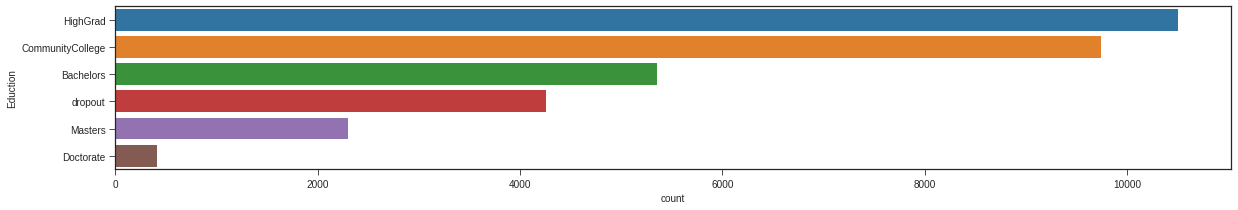

In [20]:
fig = plt.figure(figsize=(20,3))
plt.style.use('seaborn-ticks')
sns.countplot(y="Eduction", data=df, order=df['Eduction'].value_counts().index)

In [21]:
df['Martial_Status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Martial_Status, dtype: int64

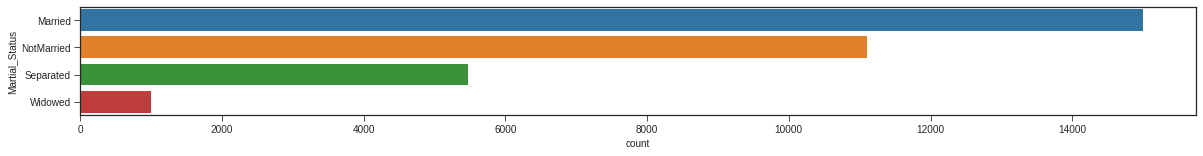

In [22]:
df['Martial_Status'].replace(' Never-married', 'NotMarried',inplace=True)
df['Martial_Status'].replace([' Married-AF-spouse'], 'Married',inplace=True)
df['Martial_Status'].replace([' Married-civ-spouse'], 'Married',inplace=True)
df['Martial_Status'].replace([' Married-spouse-absent'], 'NotMarried',inplace=True)
df['Martial_Status'].replace([' Separated'], 'Separated',inplace=True)
df['Martial_Status'].replace([' Divorced'], 'Separated',inplace=True)
df['Martial_Status'].replace([' Widowed'], 'Widowed',inplace=True)

fig = plt.figure(figsize=(20,2))
plt.style.use('seaborn-ticks')
sns.countplot(y="Martial_Status", data=df, order=df['Martial_Status'].value_counts().index)

In [23]:
# make the age variable discretized 
df['age_bin'] = pd.cut(df['Age'], 50)

<Figure size 2160x2160 with 0 Axes>

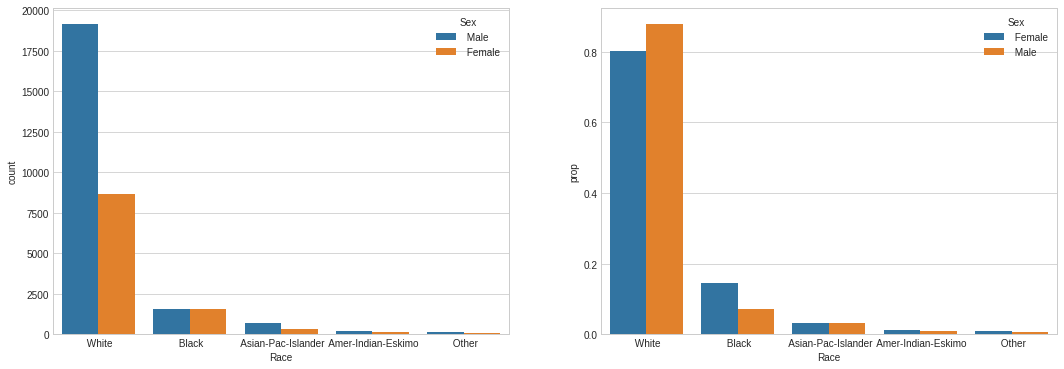

In [24]:
plt.style.use('seaborn-whitegrid')
x, y, hue = "Race", "prop", "Sex"
#hue_order = ["Male", "Female"]
plt.figure(figsize=(30,30)) 
f, axes = plt.subplots(1, 2, figsize=(18,6))
sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

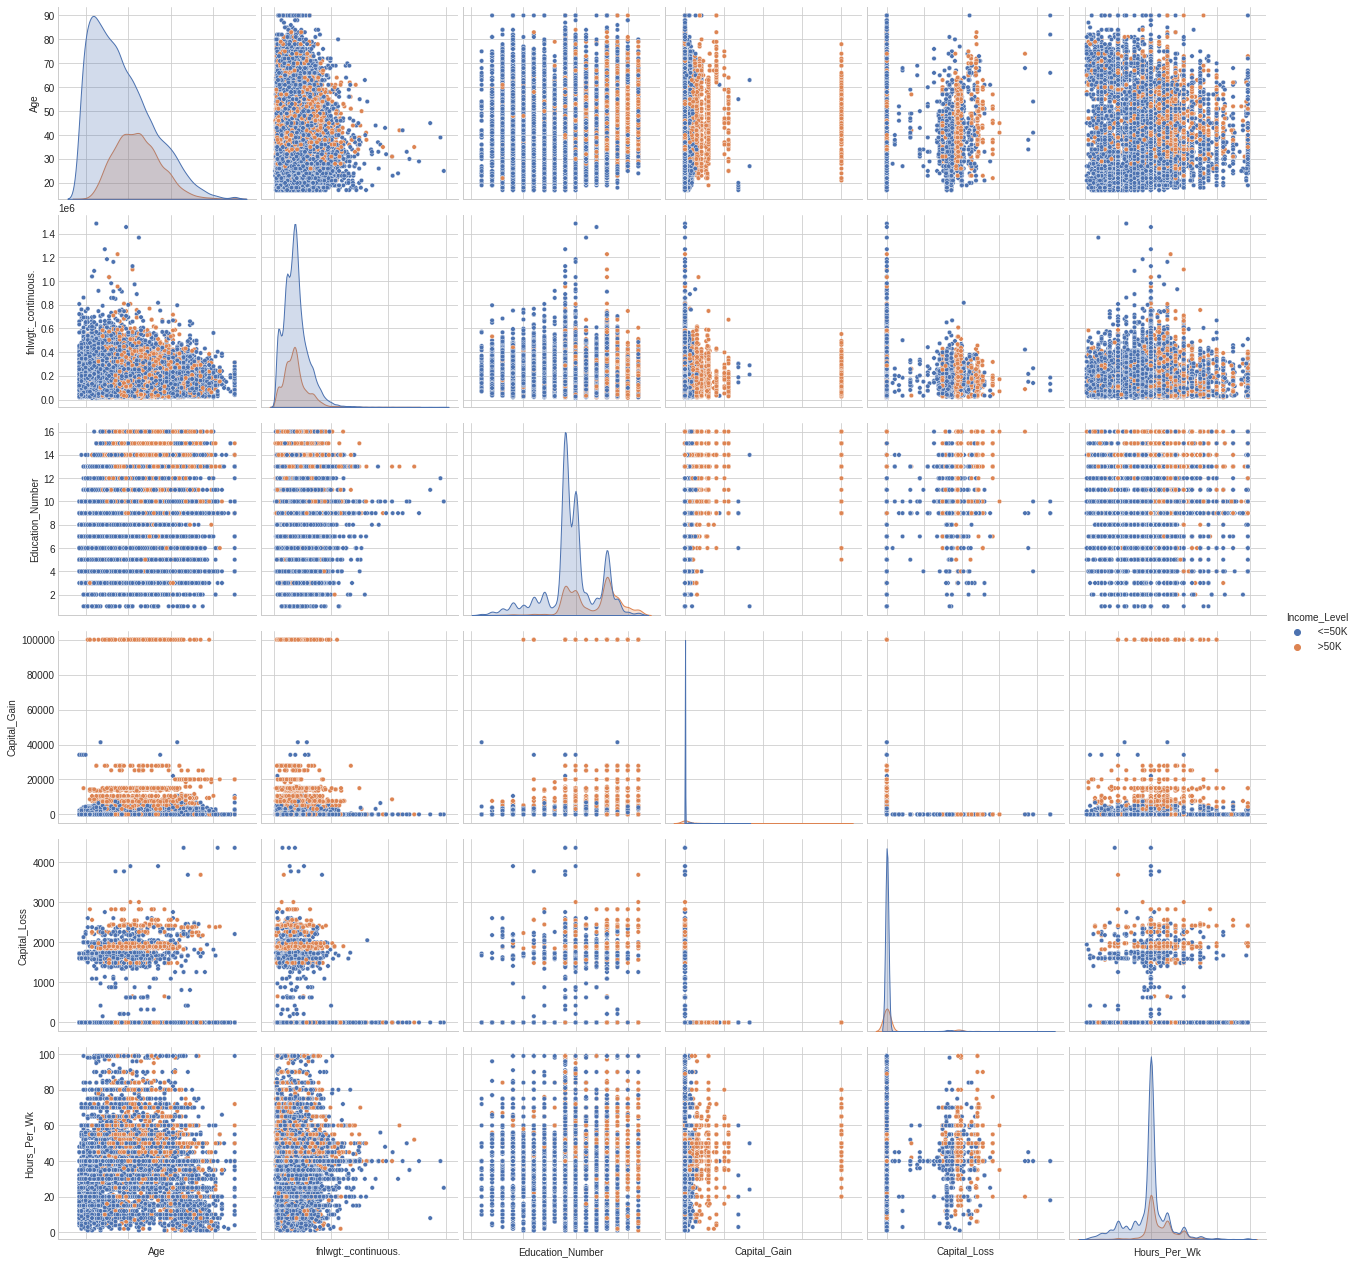

In [25]:
#pair plots of entire dataset
pp = sns.pairplot(df, hue = 'Income_Level', palette = 'deep', 
                  height=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[]);

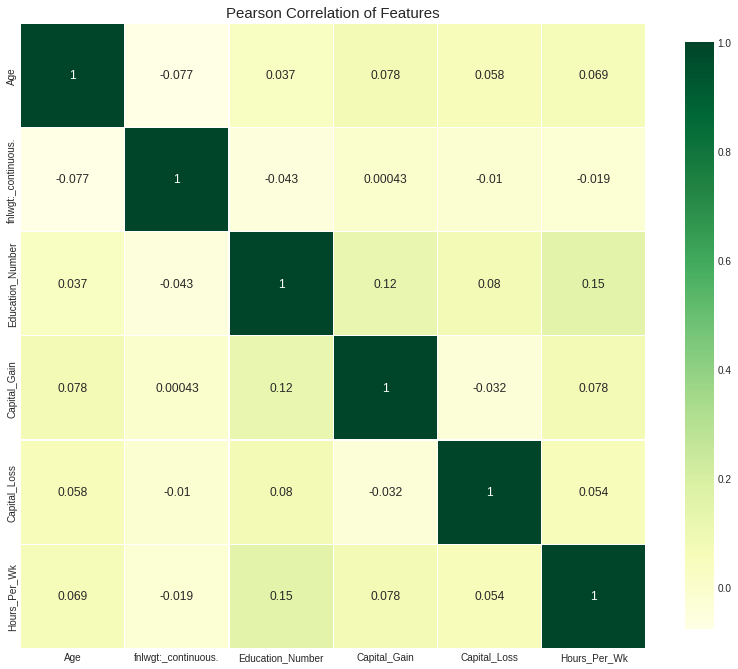

In [26]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "YlGn",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

In [27]:
#Will work on Tableau as well to do some visualization=SIVI

In [28]:
# Import

In [29]:
# df['Native Country '] = df['Native Country '].replace(['?'],['other'])


In [30]:
# df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
# df

df.columns

Index(['Age', 'Work_Class', 'fnlwgt:_continuous.', 'Eduction',
       'Education_Number', 'Martial_Status', 'Occupation', 'Relationship',
       'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk',
       'Native_Country', 'Income_Level', 'Hour_Class', 'age_bin'],
      dtype='object')

## Definition of Target Column and Predictors

In [31]:
# for dataset in df:
#   df.loc[df["Income_Level"] == '<=50K' , 'Inc_Lvl' = 0
#   df.loc[df["Income_Level"] == '>50K' , 'Inc_Lvl' = 1
#   df['not_single'] = df['not_single'].astype(int)       

In [32]:
TARGET = ['Income_Level']
columns_nom_categorical = [ 'Work_Class', 'Eduction',
      #  'Education_Number', 
       'Martial_Status', 'Occupation', 'Relationship', 'Hour_Class',
       'Race', 'Sex',  'Native_Country', 'age_bin',  ]
contin_col = ['Age', 'Hours_Per_Wk', 'Education_Number']       

In [33]:
TARGET = 'Income_Level'
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_numerical = [col for col in columns_predictors if col not in (columns_nom_categorical) ]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_nom_categorical: {columns_nom_categorical}")
# print(f"columns_ord_categorical: {columns_ord_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: Income_Level
columns_predictors: ['Age', 'Work_Class', 'fnlwgt:_continuous.', 'Eduction', 'Education_Number', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk', 'Native_Country', 'Hour_Class', 'age_bin']
columns_nom_categorical: ['Work_Class', 'Eduction', 'Martial_Status', 'Occupation', 'Relationship', 'Hour_Class', 'Race', 'Sex', 'Native_Country', 'age_bin']
columns_numerical: ['Age', 'fnlwgt:_continuous.', 'Education_Number', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk']


## Pipeline
<li> OneHot Encoder
<li> Standard Scaler

In [34]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler #specific transformations we want to use in our pipelines

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler()),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_nom_categorical),
  ("numerical", pipeline_numerical, contin_col)
])

In [35]:
X = df[columns_predictors]
y = df[TARGET]
display(X.head())
display(y.head())

,Age,Work_Class,fnlwgt:_continuous.,Eduction,Education_Number,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Wk,Native_Country,Hour_Class,age_bin
0,39,State-gov,77516,Bachelors,13,NotMarried,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,Less,"(38.9, 40.36]"
1,50,Self-emp-not-inc,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,Less,"(49.12, 50.58]"
2,38,Private,215646,HighGrad,9,Separated,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,Less,"(37.44, 38.9]"
3,53,Private,234721,dropout,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,Less,"(52.04, 53.5]"
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,Less,"(27.22, 28.68]"


0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: Income_Level, dtype: object

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=123, 
                                                    stratify=None) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (26048, 16)
X_test.shape: (6513, 16)
y_train.shape: (26048,)
y_test.shape: (6513,)


In [37]:
X_train[columns_nom_categorical]
pipeline_categorical.fit_transform(X_train[columns_nom_categorical]).toarray().shape


(26048, 140)

In [38]:
X_train.head(5)

,Age,Work_Class,fnlwgt:_continuous.,Eduction,Education_Number,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Wk,Native_Country,Hour_Class,age_bin
17064,19,Private,219300,CommunityCollege,10,NotMarried,Sales,Own-child,White,Female,0,0,25,United-States,Less,"(18.46, 19.92]"
18434,58,Private,116901,HighGrad,9,Separated,Other-service,Unmarried,White,Female,0,0,25,United-States,Less,"(57.88, 59.34]"
3294,43,Private,220589,HighGrad,9,Separated,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,Less,"(41.82, 43.28]"
31317,23,Private,50953,CommunityCollege,10,NotMarried,Tech-support,Not-in-family,White,Female,0,0,40,United-States,Less,"(22.84, 24.3]"
4770,18,Private,130849,dropout,7,NotMarried,Other-service,Own-child,White,Female,0,0,8,United-States,Less,"(16.927, 18.46]"


In [39]:
pipeline_full.fit

<bound method ColumnTransformer.fit of ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Work_Class', 'Eduction', 'Martial_Status',
                                  'Occupation', 'Relationship', 'Hour_Class',
                                  'Race', 'Sex', 'Native_Country', 'age_bin']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Age', 'Hours_Per_Wk', 'Education_Number'])])>

In [40]:
X_train.dtypes

Age                       int64
Work_Class               object
fnlwgt:_continuous.       int64
Eduction                 object
Education_Number          int64
Martial_Status           object
Occupation               object
Relationship             object
Race                     object
Sex                      object
Capital_Gain              int64
Capital_Loss              int64
Hours_Per_Wk              int64
Native_Country           object
Hour_Class             category
age_bin                category
dtype: object

In [41]:
pipeline_numerical
# columns_numerical

Pipeline(steps=[('scaler', MinMaxScaler())])

In [42]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")


X_train_transformed.shape: (26048, 143)
X_test_transformed.shape: (6513, 143)


In [43]:
pipeline_categorical.fit_transform(X_train)

<26048x18984 sparse matrix of type '<class 'numpy.float64'>'
	with 416768 stored elements in Compressed Sparse Row format>

In [44]:
X_train_transformed_nom = pipeline_categorical.fit_transform(X_train)

In [45]:
X_train_transformed_nom

<26048x18984 sparse matrix of type '<class 'numpy.float64'>'
	with 416768 stored elements in Compressed Sparse Row format>

In [46]:
X_train_transformed

<26048x143 sparse matrix of type '<class 'numpy.float64'>'
	with 338259 stored elements in Compressed Sparse Row format>

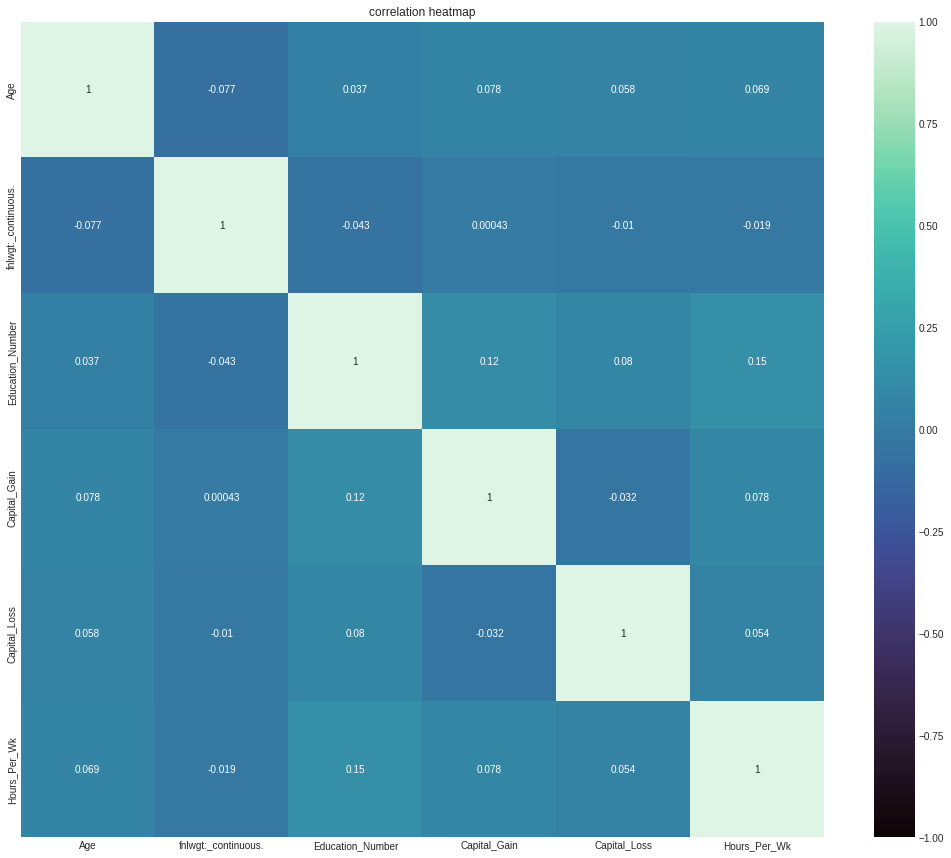

In [47]:
corr = df.corr()

plt.figure(figsize = (18,15))
sns.heatmap(corr, annot = True, vmin = -1.0, cmap = 'mako')
plt.title('correlation heatmap')
plt.show();

In [48]:
X_train[columns_nom_categorical]
pipeline_categorical.fit_transform(X_train[columns_nom_categorical]).toarray().shape

(26048, 140)

## Train Models

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


In [50]:
models = {
    LogisticRegression(n_jobs = -1): "   Logistic Regression",
    SVC():                "           Support Vector Machine",
    MLPClassifier():       "                  Neural Network",
    # KNeighborsClassifier(n_jobs=3): "                            KNN",
    RandomForestClassifier():"      Random Forest Classifier"
}

for model in models.keys():
    model.fit(X_train_transformed, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [51]:

for model , name in models.items():
    print(name+": {:.2f}%".format(model.score(X_test_transformed, y_test)*100))
    # print(name+": {:.2f}%".format(model.classification_report(y_test, X_test_transformed))) 

   Logistic Regression: 83.86%
           Support Vector Machine: 83.37%
                  Neural Network: 81.38%
      Random Forest Classifier: 82.04%


In [52]:
models.items()

dict_items([(LogisticRegression(n_jobs=-1), '   Logistic Regression'), (SVC(), '           Support Vector Machine'), (MLPClassifier(), '                  Neural Network'), (RandomForestClassifier(), '      Random Forest Classifier')])

## Random Forest on Whole Dataset

In [53]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [54]:
%%time
y_pred = rfc.predict(X_test_transformed)
print ("Classification Report")
print(classification_report(y_test, y_pred))
print ("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4927
        >50K       0.66      0.57      0.61      1586

    accuracy                           0.82      6513
   macro avg       0.77      0.74      0.75      6513
weighted avg       0.82      0.82      0.82      6513

Confusion Report
[[4469  458]
 [ 683  903]]
CPU times: user 487 ms, sys: 0 ns, total: 487 ms
Wall time: 491 ms


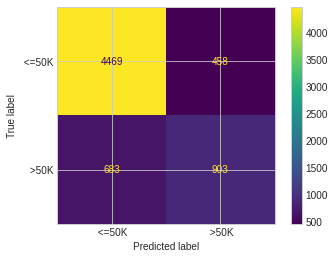

In [55]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_, )
disp.plot()

### GridSearch for RandomForest

In [56]:

# estimators = [4, 5, 10, 20, 50]
# for i in estimators:
#     model = RandomForestClassifier(random_state = 123, n_estimators=i)
#     model.fit(X_train_transformed, y_train)
#     y_pred = model.predict(X_test_transformed)
#     y_pred_proba = model.predict_proba(X_test_transformed)
#     scores = cross_val_score(model, X_test_transformed, y_test, cv = 5, scoring='neg_mean_squared_error')
#     print("Random Forest estimator = ", i)
#     print("accuracy_score: {:2.2%}".format(accuracy_score(y_test, y_pred)))
#     # print("precision_score: {:2.2%}".format( precision_score(y_test, y_pred)))
#     # print("recall_score: {:2.2%}".format(recall_score(y_test, y_pred)))
#     print("f1_score:{:2.2}".format(f1_score(y_test, y_pred)))
#     print("roc_auc_score: {:2.2}".format(roc_auc_score(y_test, y_pred_proba[:,1])))
#     print('____________')

## T-SNE dataset reduction


In [57]:
%%time
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2, n_jobs = -1)
X_reduced = reducer.fit_transform(X_train_transformed)
display(X_reduced.shape)
display(X_reduced)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(26048, 2)

array([[-82.364044 ,  14.8679495],
       [-16.063059 ,  41.497627 ],
       [-15.584543 ,  34.920773 ],
       ...,
       [-54.774654 , -39.416756 ],
       [-44.967724 , -28.986273 ],
       [-53.775288 ,  46.452026 ]], dtype=float32)

CPU times: user 11min 24s, sys: 9.68 s, total: 11min 33s
Wall time: 6min 39s


In [58]:
print(X_train.shape)
X_reduced.shape

(26048, 16)


(26048, 2)

In [59]:
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=y_train, title="TSNE", opacity = 0.3)
# fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x")
fig.show()

## Random Forest on Reduced dataset

In [60]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_reduced, y_train)

CPU times: user 4.12 s, sys: 16.9 ms, total: 4.13 s
Wall time: 4.16 s


In [61]:
%%time
reducer = TSNE(n_components=2, n_jobs = -1)
X_test_reduced = reducer.fit_transform(X_test_transformed)
display(X_test_reduced.shape)
display(X_test_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(6513, 2)

array([[-42.534767 , -59.725315 ],
       [-21.941694 , -59.54225  ],
       [-13.1359625,  59.775616 ],
       ...,
       [ 67.64138  , -25.258625 ],
       [-53.387653 , -53.058277 ],
       [ 36.81278  , -41.93143  ]], dtype=float32)

CPU times: user 2min 2s, sys: 1.16 s, total: 2min 4s
Wall time: 1min 8s


In [62]:
print(X_test_reduced.shape)


(6513, 2)


#### Evaluation F1, precision etc

In [63]:
# %%time
y_pred = rfc.predict(X_test_reduced)
print ("Classification Report")
print(classification_report(y_test, y_pred))
print ("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

       <=50K       0.75      0.80      0.78      4927
        >50K       0.24      0.19      0.21      1586

    accuracy                           0.65      6513
   macro avg       0.50      0.50      0.49      6513
weighted avg       0.63      0.65      0.64      6513

Confusion Report
[[3935  992]
 [1278  308]]


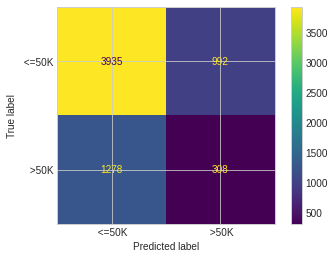

In [64]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## PCA Reducer

In [89]:
X_train_transformed.shape

(26048, 143)

In [ ]:
# from sklearn.decomposition import SparsePCA
# from sklearn.decomposition import PCA

# reducer = PCA(n_components = 0.95)
# X_reduced = reducer.fit_transform(X_train_transformed)
# display(X_reduced.shape)
# display(X_reduced)
# fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color = y, title="PCA")
# fig.update_layout(height=1000)
# fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
# fig.show()

# Tuning Model
<li> Next Steps
<li> Panthea - Tuning hyper parameters - cross valdiation (precision, ROC), Gridsearch
<li> Unsuperivesd Learning to tune target

<li> Reduction of dimensionalty - apply this before classification


In [67]:
df = data.copy()

In [68]:
df.groupby([ 'Race'])['Age'].agg({'mean', 'count'})

,mean,count
Race,,
Amer-Indian-Eskimo,37.173633,311
Asian-Pac-Islander,37.746872,1039
Black,37.767926,3124
Other,33.457565,271
White,38.769881,27816


## Explore the data balance

In [69]:
# df['hours'] = df(df['Hours Per Wk']> 60, 'more', df['Hours Per Wk']<= 60, "less")

In [70]:
df.dtypes

Age                     int64
Work_Class             object
fnlwgt:_continuous.     int64
Eduction               object
Education_Number        int64
Martial_Status         object
Occupation             object
Relationship           object
Race                   object
Sex                    object
Capital_Gain            int64
Capital_Loss            int64
Hours_Per_Wk            int64
Native_Country         object
Income_Level           object
dtype: object

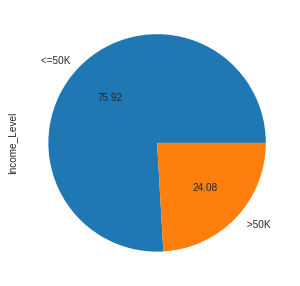

In [71]:
df = df.groupby(['Income_Level'])['Income_Level'].count()
df.plot.pie(figsize=(5,5), autopct="%.2f")

In [72]:
# df.groupby(['Race'])['Age'].agg({'mean', 'count'})

In [73]:
# df.groupby([ 'Native_Country'])['Age'].agg({'mean', 'count'})

In [74]:
df.isnull().sum()

0

## Grouping features into cat, cont categories

In [75]:
df.nunique()

2

In [76]:
target = ['Income Level']

contin_var = ["Age", 'fnlwgt: continuous.', 'Hours Per Wk ' ,'Capital Gain', 'Capital Loss', ]

cat_var= ["Work Class" , "Education Number", 'Education Number']

categ_string_var = ['Martial Status', 'Occupation', 'Relationship',
       'Race', 'Sex',]

In [ ]:
# df.loc[:, contin_var + cat_var + categ_string_var].hist(bins = 50, figsize=(12, 8))
# plt.show()

## Decision Tree

### Hard Voting

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf) ],
    voting='hard')

voting_clf.fit(X_train_transformed, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed);
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression 0.8386304314448026
RandomForestClassifier 0.8248119146322739
KNeighborsClassifier 0.8238906801781053


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier 0.8350990327038231


### Soft Voting

In [79]:
%%time
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf) ],
    voting='soft')

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed);
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression 0.8386304314448026
RandomForestClassifier 0.8234300629510211
KNeighborsClassifier 0.8238906801781053


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier 0.8363273453093812
CPU times: user 1min 13s, sys: 3.36 s, total: 1min 16s
Wall time: 1min 17s


### Bagging not transformed datasets

In [80]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=50,
    max_samples=90, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train_transformed, y_train)
y_pred = bag_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.820205742361431


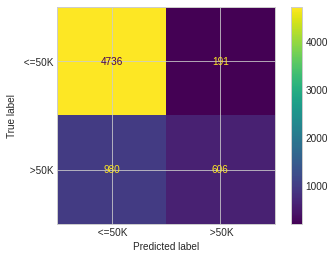

In [81]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

rnd_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train_transformed, y_train)

y_pred = rnd_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8223552894211577


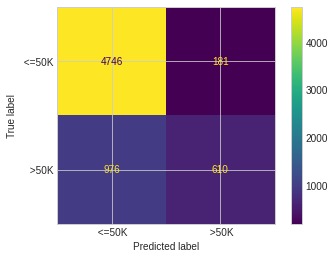

In [83]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## Extremely Randomized Trees

In [84]:
from sklearn.ensemble import ExtraTreesClassifier


forest = ExtraTreesClassifier(n_estimators=5)
forest.fit(X_train_transformed, y_train)
y_pred = forest.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8051589129433441


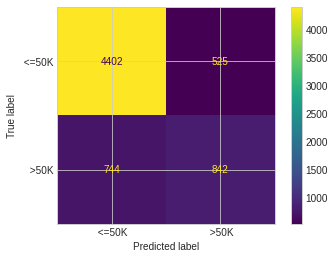

In [85]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## ADA BOOST

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_transformed, y_train)
y_pred = ada_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8413941348073085


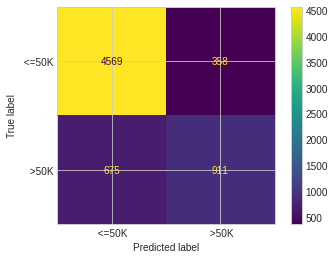

In [87]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

### Gradient Boosting (Ramila)

### ADA Boost Classifier (Panthea)